In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
model = keras.models.load_model('cats_and_dogs_small_2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)       147584    
__________

# Visualizing intermediate activations

In [3]:
img_path = '/content/dohai90/datasets/dogs_vs_cats_data/small_set/test/cats/cat.1700.jpg'

img = keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
img_tensor = keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


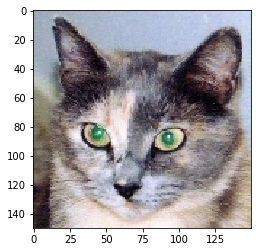

In [4]:
# plot the image
plt.imshow(keras.preprocessing.image.array_to_img(np.squeeze(img_tensor)))
plt.show()

In [5]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [6]:
# running the model in predict mode
activations = activation_model.predict(img_tensor)

In [7]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


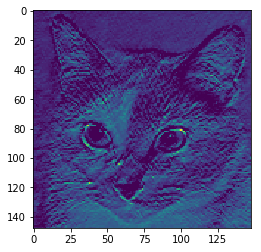

In [8]:
plt.imshow(first_layer_activation[0, :, :, 4], cmap=plt.cm.viridis)
plt.show()

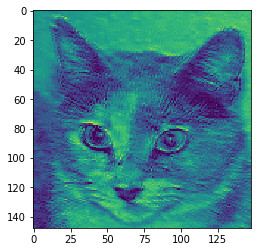

In [9]:
plt.imshow(first_layer_activation[0, :, :, 7], cmap=plt.cm.viridis)
plt.show()

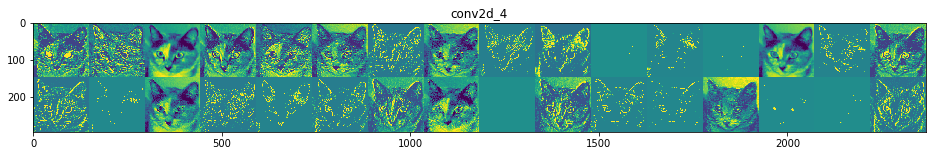

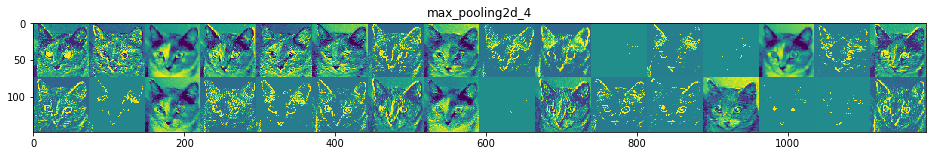

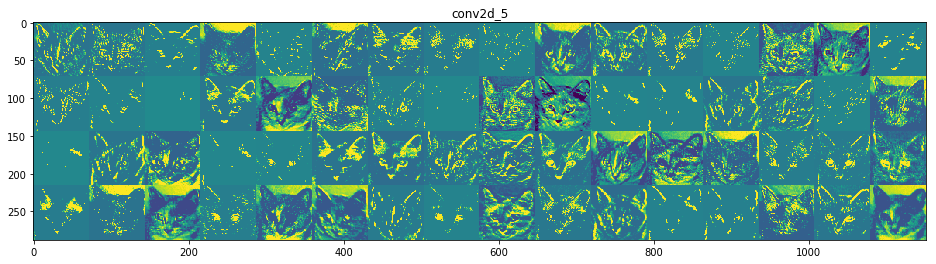

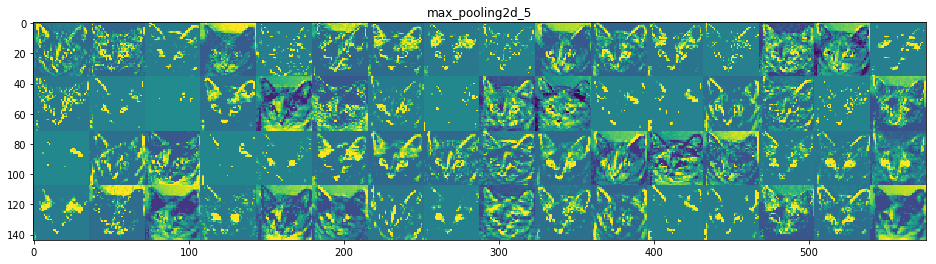

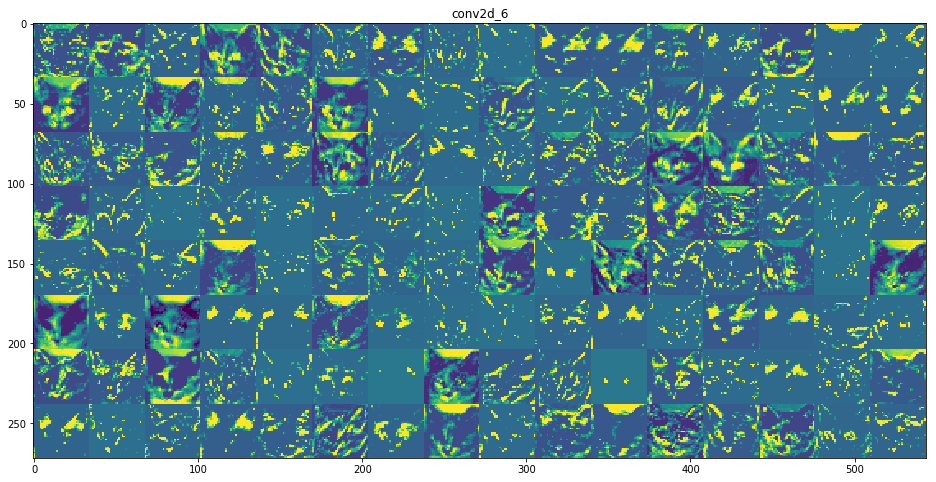

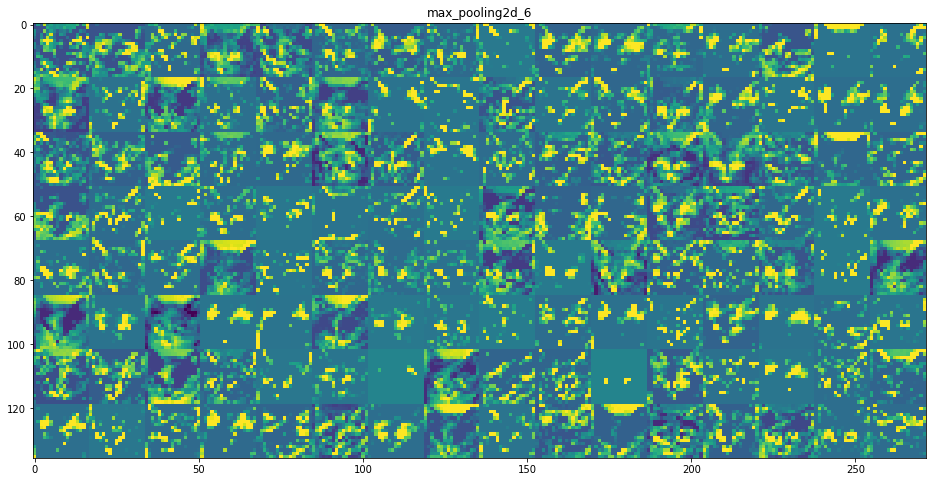

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


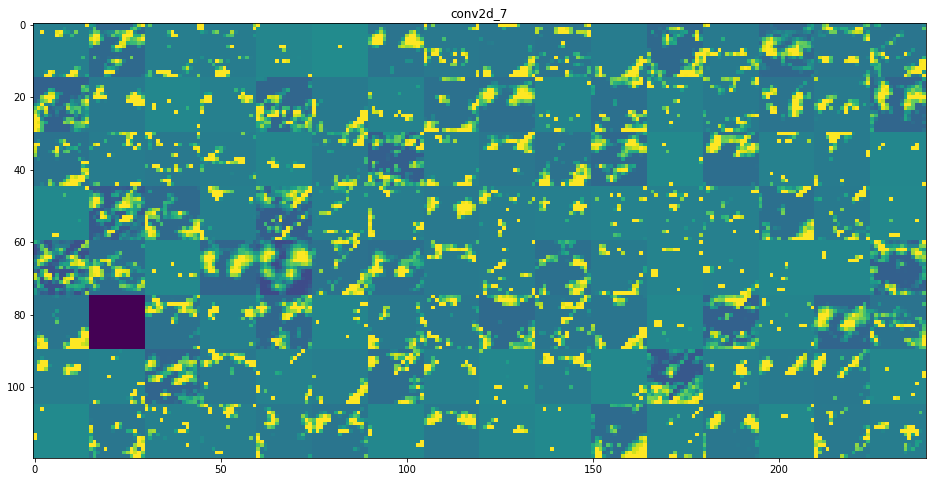

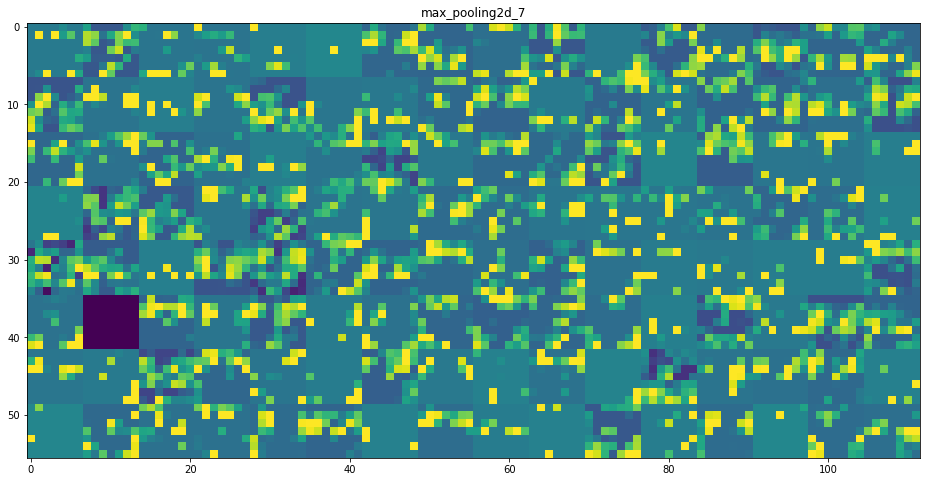

In [10]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    
    n_rows = n_features // images_per_row
    display_grid = np.zeros((n_rows * size, images_per_row * size))
    
    for row in range(n_rows):
        for col in range(images_per_row):
            channel_image = layer_activation[0, :, :, row * images_per_row + col]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype(np.uint8)
            display_grid[row * size : (row + 1) * size, col * size : (col + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap=plt.cm.viridis)
    plt.show()

# Visualizing convnet filters

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

In [12]:
# utility func to convert a tensor into a valid image
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x * 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype(np.uint8)
    return x

# func to generate filter visualizations
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    
    input_image_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_image_data])
        input_image_data += grads_value * step
        
    img = input_image_data[0]
    return deprocess_image(img)

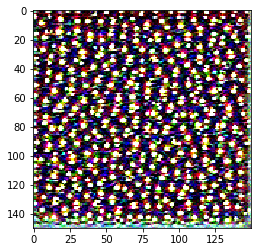

In [13]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


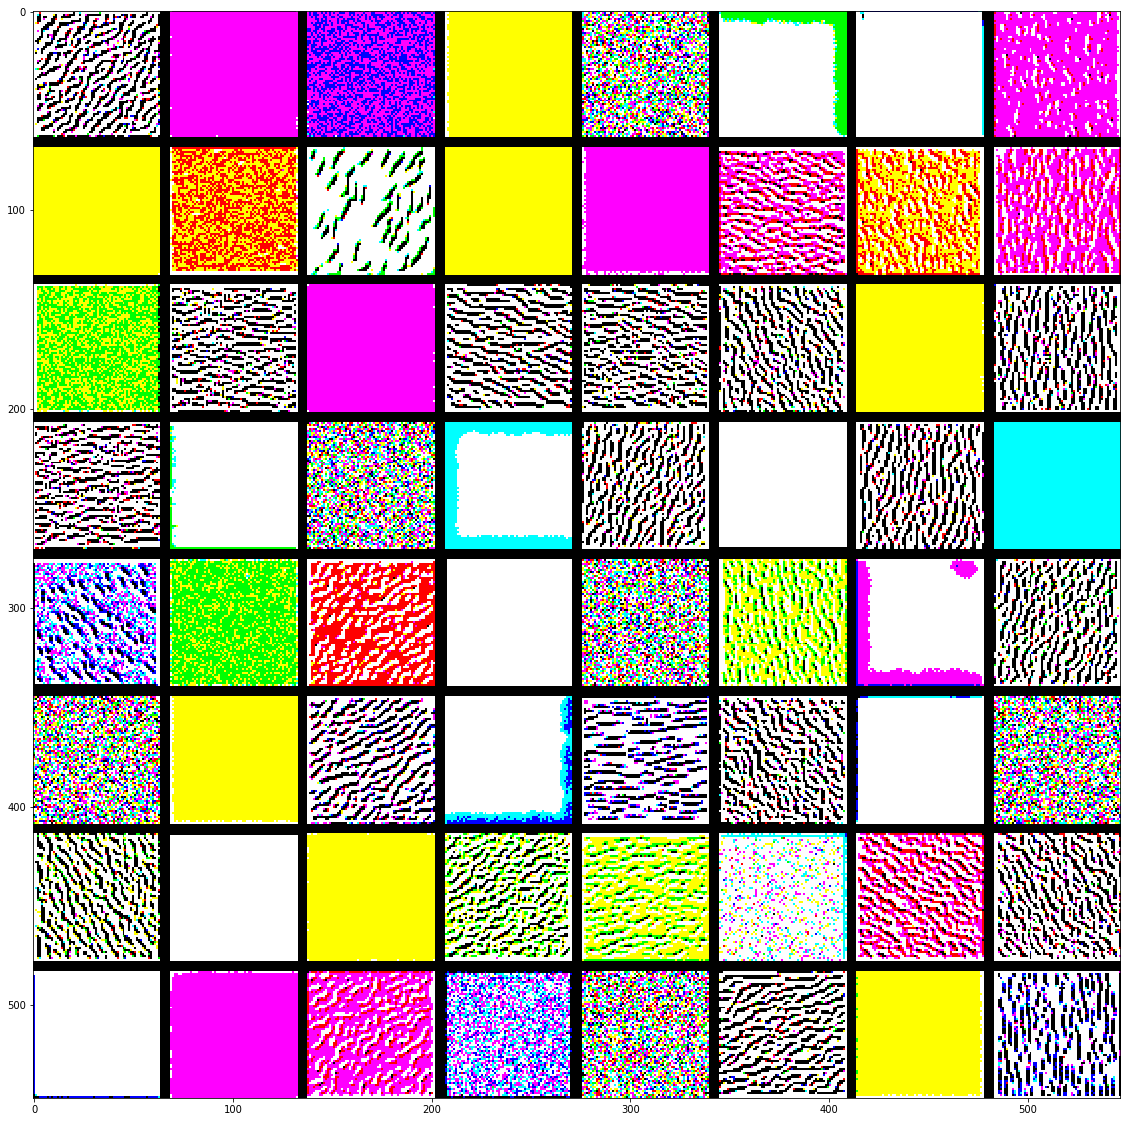

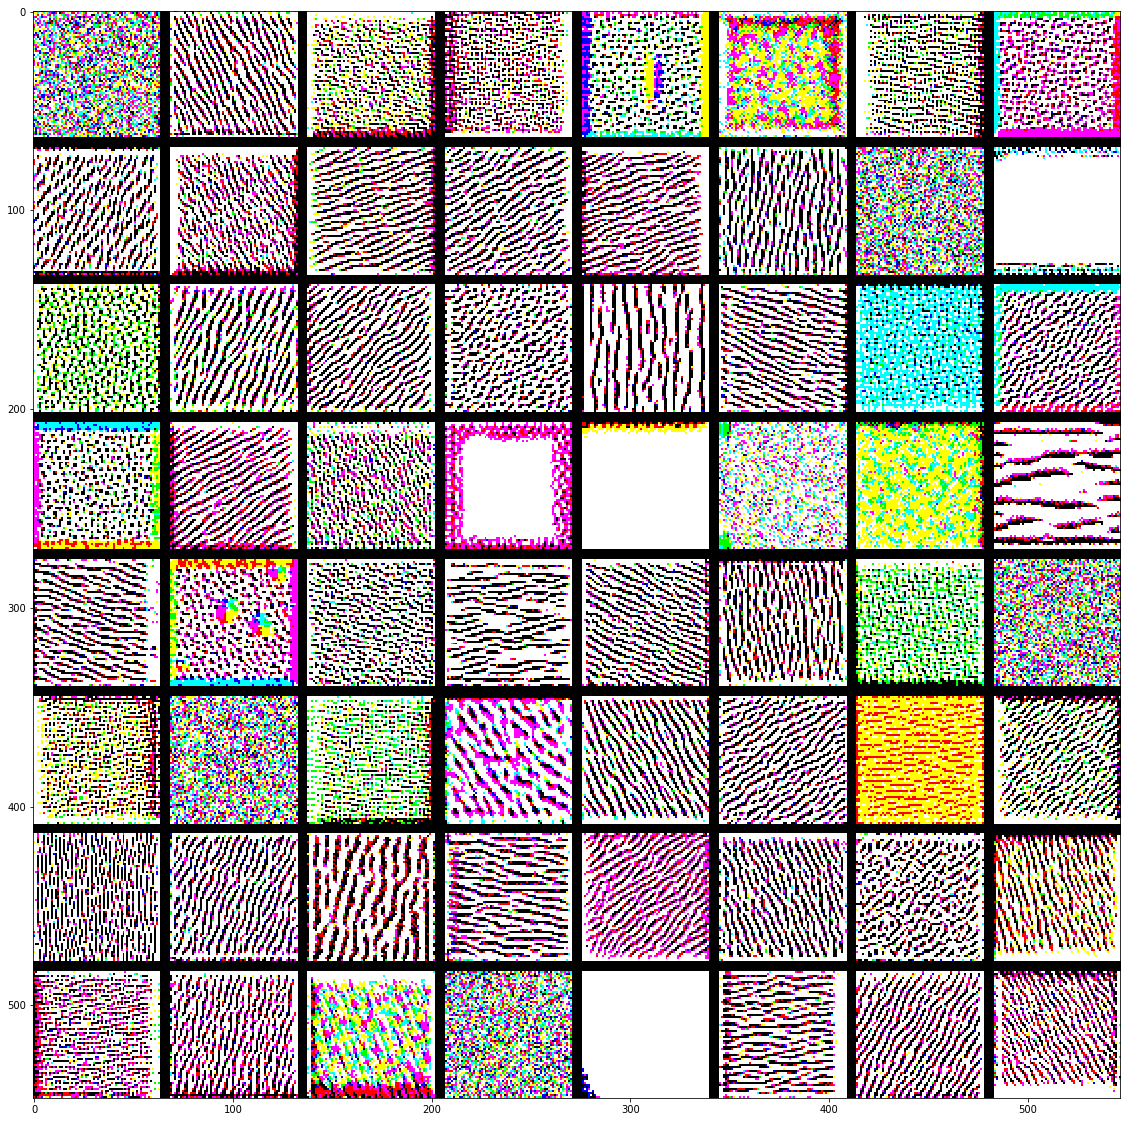

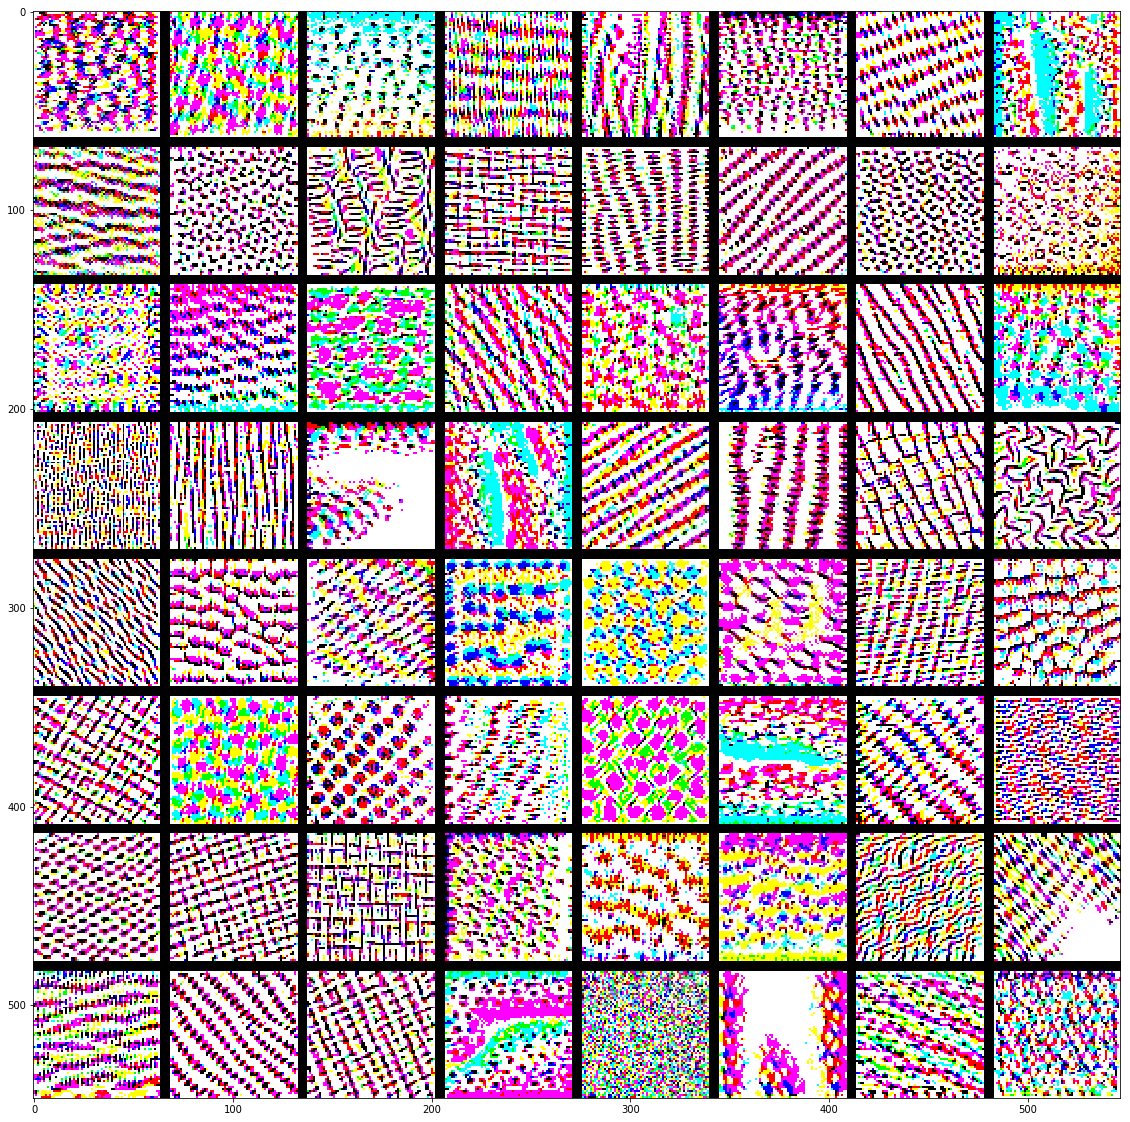

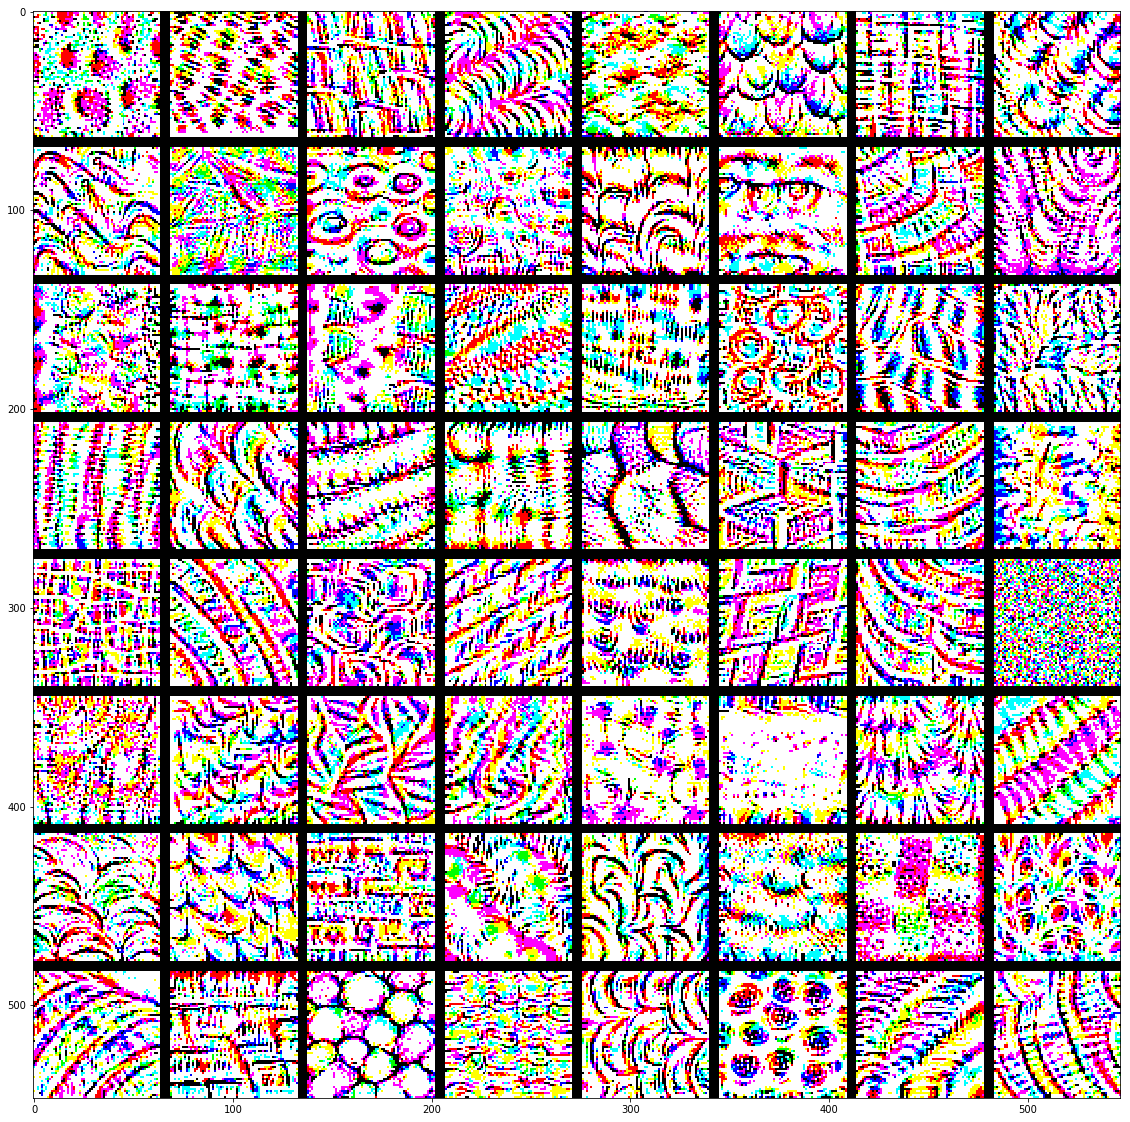

In [14]:
# generating a grid of all filter response patterns in a layer
layer_names = ['block{}_conv1'.format(i) for i in range(1, 5)]
size = 64
margin = 5

for layer_name in layer_names:
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i * 8 + j, size=size)

            horizontal_start = j * size + j * margin
            horizontal_end = horizontal_start + size
            vertical_start = i * size + i * margin
            vertical_end = vertical_start + size
            results[horizontal_start : horizontal_end, vertical_start : vertical_end, :] = filter_img

    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show

# Visualizing heatmaps of class activation

In [15]:
model = VGG16(weights='imagenet')

In [16]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [17]:
img_path = '/content/dohai90/workspace/keras/creative_commons_elephant.JPG'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.7938616), ('n01871265', 'tusker', 0.17495263), ('n02504013', 'Indian_elephant', 0.030991077)]


In [18]:
np.argmax(preds[0])

386

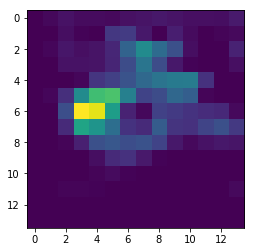

In [19]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heat_map = np.mean(conv_layer_output_value, axis=-1)
heat_map = np.maximum(heat_map, 0)
heat_map /= np.max(heat_map)
plt.imshow(heat_map)
plt.show()

In [20]:
import cv2

In [21]:
img = cv2.imread(img_path)
heat_map = cv2.resize(heat_map, (img.shape[1], img.shape[0]))
heat_map =np.uint8(255 * heat_map)
heat_map = cv2.applyColorMap(heat_map, cv2.COLORMAP_JET)
superimposed_img = heat_map * 0.4 + img
cv2.imwrite('/content/dohai90/workspace/keras/elephant_cam.JPG', superimposed_img)

True